In [45]:
# standard python imports
import sys
sys.path.append("/home/conradb/git/ifg-ssl")
from PIL import Image
from collections import defaultdict, Counter, OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import math

# pytorch imports
import torch
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

# local module imports
from dino.augment import IfgAugmentationDINO
from dino.loss import DINOLoss
import dino.utils as utils
import dino.vision_transformer as vit
from dino.vision_transformer import DINOHead
from dino.image_folder_tar import ImageFolderTar

In [2]:
# augmentations
global_crops_scale = (0.4, 1.)
local_crops_scale = (0.05, 0.4)
local_crops_number = 8

# dataloader
batch_size = 128 #cpu
num_workers = 8
pin_memory = False #cpu

# model
model = 'vit_tiny' # embed_dim=192, depth=12, num_heads=3
out_dim = 16384 # complex and large datasets values like 65k work well
use_bn_head = False # use batch norm in head
norm_last_layer = True #  normalize the last layer of the DINO head, typically set this paramater to False with vit_small and True with vit_base

# dino specific
warmup_teacher_temp = 0.02 # Initial value for the teacher temperature, Try decreasing it if the training loss does not decrease
teacher_temp = 0.04
warmup_teacher_temp_epochs = 30 # 30 is default?

# compute
device ='cpu' # cpu or gpu

epochs = 100
# lr = 0.0005
lr = 5e-2
# min_lr = 1e-6
min_lr=5e-4
warmup_epochs = 10
weight_decay = 0.04
weight_decay_end = 0.4
# momentum_teacher = 0.996 # Base EMA parameter for teacher update. The value is increased to 1 during training with cosine schedule. We recommend setting a higher value with small batches: for example use 0.9995 with batch size of 256.""")
momentum_teacher = 0.99

In [3]:
import os
path = os.path.join(os.getcwd(), 'ifg-ssl')

In [4]:
print(path)

/home/conradb/git/ifg-ssl


In [5]:
transform = IfgAugmentationDINO(global_crops_scale, local_crops_scale, local_crops_number)
dataset = datasets.ImageFolder(root='/scratch/SDF25/Hephaestus_Classification/InSARLabelled', transform=transform)

In [6]:
print(dataset.targets)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [7]:
# Stratified Sampling for train and val
train_idx, validation_idx = train_test_split(np.arange(len(dataset)),
                                             test_size=0.2,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=dataset.targets)

In [8]:
# Subset dataset for train and val
train_dataset = Subset(dataset, train_idx)
validation_dataset = Subset(dataset, validation_idx)

In [9]:
print(len([dataset.targets[i] for i in train_idx]))

172884


In [38]:
# Weighted sampling to address class imbalance

targets = [dataset.targets[i] for i in train_idx]

c = Counter(targets)
c = OrderedDict(sorted(c.items()))
print(c)
length = 0
for value in c.values():
    length += int(value)
assert length == len(train_dataset)

# calcuate weight of each class
class_weights = [1.0/n for n in c.values()]
print(class_weights)

# assign weight to each sample
sample_weights = [class_weights[n] for n in targets]

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# assign sampler
train_dataloader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, drop_last=True)

OrderedDict([(0, 171087), (1, 343), (2, 418), (3, 931), (4, 23), (5, 44), (6, 38)])
[5.844979454897216e-06, 0.0029154518950437317, 0.0023923444976076554, 0.0010741138560687433, 0.043478260869565216, 0.022727272727272728, 0.02631578947368421]


In [39]:
one_sample = next(iter(train_dataloader))
print(len(one_sample[0])) # crops
print(len(one_sample[1])) # labels
print(one_sample[0][9].shape)

10
128
torch.Size([128, 3, 96, 96])


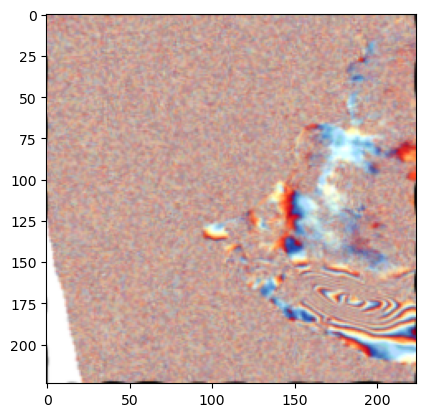

In [40]:
plt.imshow(one_sample[0][1][49].permute(1,2,0).numpy())

In [ ]:
####### COMPUTE MEAN / STD

# placeholders
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs, _ in train_dataloader:
    psum += inputs.sum(axis=[0, 2, 3])
    psum_sq += (inputs**2).sum(axis=[0, 2, 3])

# pixel count
count = (len(train_dataloader)*128) * 224 * 224 #n_batches x batch_size x pixel height x pixel width

# mean and std
total_mean = psum / count
total_var = (psum_sq / count) - (total_mean**2)
total_std = torch.sqrt(total_var)

# output
print("mean: " + str(total_mean))
print("std:  " + str(total_std))

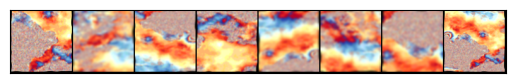

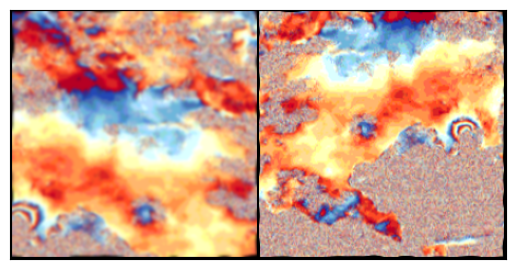

In [29]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.permute(1,2,0)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


list_local = [*one_sample[0][2:10]] # grab local crops
list_global = [*one_sample[0][0:2]] # grab global crops
grid_local = make_grid([a[79] for a in list_local], nrow=8) # where n in a[n] is a batch sample
grid_global = make_grid([a[79] for a in list_global], nrow=2) # where n in a[n] is a batch sample
show(grid_local)
show(grid_global)

In [30]:
print(one_sample[1])

tensor([3, 2, 0, 3, 5, 4, 2, 2, 5, 4, 0, 2, 1, 4, 3, 0, 0, 6, 3, 6, 3, 0, 6, 2,
        0, 0, 3, 1, 3, 4, 2, 1, 0, 0, 0, 4, 3, 4, 1, 4, 1, 6, 3, 6, 0, 6, 3, 3,
        0, 0, 1, 5, 6, 3, 0, 5, 5, 3, 1, 3, 4, 6, 6, 0, 5, 5, 4, 0, 6, 1, 2, 0,
        1, 3, 4, 6, 6, 5, 6, 4, 6, 4, 2, 4, 3, 2, 5, 2, 6, 1, 6, 6, 1, 0, 1, 3,
        3, 2, 4, 3, 3, 4, 2, 1, 6, 5, 3, 1, 5, 6, 2, 3, 4, 3, 5, 5, 2, 1, 1, 1,
        3, 2, 6, 0, 4, 0, 6, 6])


In [31]:
student = vit.__dict__[model](patch_size=16, drop_path_rate=0.1)
teacher = vit.__dict__[model](patch_size=16)
embed_dim = student.embed_dim

In [32]:
# multi-crop wrapper handles forward with inputs of different resolutions
student = utils.MultiCropWrapper(student, DINOHead(embed_dim, out_dim, use_bn=use_bn_head, norm_last_layer=norm_last_layer))
teacher = utils.MultiCropWrapper(teacher, DINOHead(embed_dim, out_dim, use_bn=use_bn_head))

/home/conradb/mambaforge/envs/ml/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [33]:
if device == 'gpu':
    student, teacher = student.cuda(), teacher.cuda()
else:
    student, teacher = student.cpu(), teacher.cpu()

In [34]:
teacher.load_state_dict(student.state_dict())

<All keys matched successfully>

In [35]:
# there is no backpropagation through the teacher, so no need for gradients
for p in teacher.parameters():
    p.requires_grad = False

In [36]:
dino_loss = DINOLoss(
        out_dim,
        local_crops_number + 2,  # total number of crops = 2 global crops + local_crops_number
        warmup_teacher_temp,
        teacher_temp,
        warmup_teacher_temp_epochs,
        epochs,
        )

if device == 'gpu':
    dino_loss = dino_loss.cuda()
else:
    dino_loss = dino_loss.cpu()

In [37]:
params_groups = utils.get_params_groups(student)
optimizer = torch.optim.AdamW(params_groups)  # to use with ViTs

In [41]:
lr_schedule = utils.cosine_scheduler(lr, min_lr, epochs, len(train_dataloader), warmup_epochs=warmup_epochs)

wd_schedule = utils.cosine_scheduler(weight_decay, weight_decay_end, epochs, len(train_dataloader))

# momentum parameter is increased to 1. during training with a cosine schedule
momentum_schedule = utils.cosine_scheduler(momentum_teacher, 1, epochs, len(train_dataloader))

In [46]:
for epoch in range(0, epochs):

    running_loss = 0
    counts = 0

    for it, (images, _) in enumerate(train_dataloader):

        it = len(train_dataloader) * epoch + it  # global training iteration

        for i, param_group in enumerate(optimizer.param_groups):
            param_group["lr"] = lr_schedule[it]
            if i == 0:  # only the first group is regularized
                param_group["weight_decay"] = wd_schedule[it]

        # teacher and student forward passes + compute dino loss
        teacher_output = teacher(images[:2])  # only the 2 global views pass through the teacher
        student_output = student(images)
        loss = dino_loss(student_output, teacher_output, epoch)

        running_loss += loss
        counts += 1

        if not math.isfinite(loss.item()):
            print("Loss is {}, stopping training".format(loss.item()), force=True)
            sys.exit(1)

        # student update
        optimizer.zero_grad()
        param_norms = None
        loss.backward()

        param_norms = utils.clip_gradients(student, 3.0)
        utils.cancel_gradients_last_layer(epoch, student, 1)
        optimizer.step()

        # EMA update for the teacher
        with torch.no_grad():
            m = momentum_schedule[it]  # momentum parameter
            for param_q, param_k in zip(student.parameters(), teacher.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)

    epoch_loss = running_loss / counts
    print(f'Epoch {epoch} loss is {epoch_loss}')

    if epoch % 5 == 0:

        save_dict = {
            'student': student.state_dict(),
            'teacher': teacher.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch + 1,
            'dino_loss': dino_loss.state_dict(),
            }
        
        # torch.save(save_dict, 'dino/dino_checkpoints/dino_hephaestus_160_ckpt_cpu.pth')

KeyboardInterrupt: 